In [1]:
%autosave 0

Autosave disabled


In [2]:
from tensorflow.python.ops import gen_image_ops

# TensorFlow Serving

The project involves the deployment of a machine learning model using TensorFlow Serving and a Flask-based gateway service. The application architecture comprises two main components: a Docker container housing TensorFlow Serving for serving the machine learning model, and a Flask application acting as the gateway service.

## 1. Load the trained model

In [3]:
import tensorflow as tf
from tensorflow import keras

Unzip the compressed folder containing the trained model (in TensorFlow SavedModel format).

In [ ]:
!tar -xf "./exported_model.zip"

# Rename the folder as kangaroo_model
!mv exported_model kangaroo_model

In [ ]:
# Explore the model
!tree kangaroo_model

```bash
$ tree kangaroo_model

kangaroo_model
┣╸ assets
┣╸ saved_model.pb
┗╸ variables
    ┣╸ variables.data-00000-of-00001
    ┗╸ variables.index
```

In [ ]:
!ls -lhr kangaroo_model

## 2. TensorFlow Serving with Docker

We can look what's inside in the saved model using the utility (`saved_model_cli`) from tensorflow and the command `saved_model_cli show --dir model-dir-name --all`. Running the command outputs few things but we are interested in the signature, specifically `signature_def['serving_default']`, which shows the inputs and outputs of the model. For instance, the example model has 1 input ( `inputs`) and 5 outputs (`detection_boxes`, `detection_classes`, `detection_scores`, `image_info`, and `num_detections`).    

```bash
$ saved_model_cli show --dir kangaroo_model --all

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_UINT8
        shape: (1, -1, -1, 3)
        name: serving_default_inputs:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['detection_boxes'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, 100, 4)
        name: StatefulPartitionedCall:0
    outputs['detection_classes'] tensor_info:
        dtype: DT_INT32
        shape: (1, 100)
        name: StatefulPartitionedCall:1
    outputs['detection_scores'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, 100)
        name: StatefulPartitionedCall:2
    outputs['image_info'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, 4, 2)
        name: StatefulPartitionedCall:3
    outputs['num_detections'] tensor_info:
        dtype: DT_INT32
        shape: (1)
        name: StatefulPartitionedCall:4
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: 'inference_for_tflite'

  Function Name: 'inference_from_image_bytes'

  Function Name: 'inference_from_image_tensors'
    Option #1
      Callable with:
        Argument #1
          inputs: TensorSpec(shape=(1, None, None, 3), dtype=tf.uint8, name='inputs')

  Function Name: 'inference_from_tf_example'
```

Run the model (`kangaroo_model`) with the prebuilt docker image `tensorflow/serving:2.7.0`:

```bash
$ docker run -it --rm \
  -p 8500:8500 \
  -v $(pwd)/kangaroo_model:/models/kangaroo_model/1 \
  -e MODEL_NAME="kangaroo_model" \
  tensorflow/serving:2.7.0
```

* docker run -it --rm (to run the docker)
* -p 8500:8500 (port mapping)
* -v $(pwd)/kangaroo_model:/models/kangaroo_model/1 (volume mapping of absolute model directory to model directory inside the docker image. "models/model_name/version")
* -e MODEL_NAME="kangaroo_model" (set environment variable for docker image)
* tensorflow/serving:2.7.0 (name of the image to run)

### Establish gRPC Connection to TensorFlow Serving

In [ ]:
# Install required libraries
!pip install grpcio==1.42.0 tensorflow-serving-api==2.7.0

In [5]:
import grpc

import tensorflow as tf

from tensorflow_serving.apis import prediction_service_pb2_grpc
from tensorflow_serving.apis import predict_pb2

The stub is a client-side object that allows the code to make remote calls to the `PredictionService` using the specified communication channel.

In [6]:
host = 'localhost:8500'

channel = grpc.insecure_channel(host)

stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

In [7]:
# Preprocess input image using tf utils.
import requests 

def preprocess_input_image(image_path, input_image_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, input_image_size)
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, dtype=tf.uint8)
    image_np = image.numpy()
    
    return image_np

def preprocess_input_image_from_url(image_url, input_image_size):
    image = requests.get(image_url).content
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, input_image_size)
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, dtype=tf.uint8)

    image_np = image.numpy()
    
    return image_np 


HEIGHT, WIDTH = 256, 256
input_image_size = (HEIGHT, WIDTH)

# Set input image from path:
image_path = "./images/kangaroo-1.jpg"
image_np = preprocess_input_image(image_path, input_image_size)


# Set input image from URL:
image_url = "https://ichef.bbci.co.uk/news/976/cpsprodpb/1622F/production/_96717609_mediaitem96715861.jpg"
image_np = preprocess_input_image_from_url(image_url, input_image_size)

In [8]:
def np_to_protobuf(data):
    return tf.make_tensor_proto(data, shape=data.shape)

Tensorflow uses specical serving called `gRPC` protocol which is optimized to use binary data format. We need to convert the inputs for our prediction request into `protobuf` format.

np_to_protobuf(image_np)

```
dtype: DT_UINT8
tensor_shape {
  dim {
    size: 1
  }
  dim {
    size: 256
  }
  dim {
    size: 256
  }
  dim {
    size: 3
  }
}
tensor_content: "\242\236k\245\237l\...
```

### Prepare Prediction Request

`PredictRequest` is used to encapsulate the input data or parameters (model name, model's signature name, and input in `protobuf` format) that the client wants to send to the server when making a prediction.

In [9]:
def prepare_request(image_np):
    pb_request = predict_pb2.PredictRequest()
    pb_request.model_spec.name = 'kangaroo_model'
    pb_request.model_spec.signature_name = 'serving_default'

    pb_request.inputs['inputs'].CopyFrom(np_to_protobuf(image_np))
    
    return pb_request

pb_request = prepare_request(image_np)

pb_request
```bash
model_spec {
  name: "kangaroo_model"
  signature_name: "serving_default"
}
inputs {
  key: "inputs"
  value {
    dtype: DT_UINT8
    tensor_shape {
      dim {
        size: 1
      }
      dim {
        size: 256
      }
      dim {
        size: 256
      }
      dim {
        size: 3
      }
    }
    tensor_content: "\242\236k\245\237l...
```

### Make Prediction Request

The `Predict()` method returns a response object with a value in `Protobuf` format.

In [10]:
pb_response = stub.Predict(pb_request, timeout=20.0)

In [ ]:
pb_response

pb_response

```
outputs {
  key: "detection_boxes"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 1
      }
      dim {
        size: 100
      }
      dim {
        size: 4
      }
    }
    float_val: 43.23219299316406
    float_val: 57.41709899902
    ...
```

### Retrieve and Interpret Model Output

In [ ]:
# Install required libraries

!pip install -q "tf-models-official==2.10.0"
!pip install -U tensorflow-datasets==4.8.3
!pip install Pillow==9.5.0

In [12]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

import matplotlib.pyplot as plt

C:\Users\Javier\miniconda3\envs\ml-zoomcamp\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Javier\miniconda3\envs\ml-zoomcamp\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file

In [13]:
category_index={
    1: {
        'id': 1,
        'name': 'kangaroo'
       },
}

In [15]:
plt.figure(figsize=(20, 20))
min_score_thresh = 0.70  # Change minimum score for threshold

result = pb_response.outputs

visualization_utils.visualize_boxes_and_labels_on_image_array(  
    image_np[0],
    tf.make_ndarray(result['detection_boxes'])[0],
    tf.make_ndarray(result['detection_classes'])[0],
    tf.make_ndarray(result['detection_scores'])[0],
    category_index=category_index,
    use_normalized_coordinates=False,
    max_boxes_to_draw=200,  # 200
    min_score_thresh=min_score_thresh,
    agnostic_mode=False,
    instance_masks=None,
    line_thickness=4
)

plt.imshow(image_np[0])
plt.axis('off')
plt.plot()
plt.savefig(f"./inferences/inference.jpg", dpi=10)

plt.show()

C:\Users\Javier\AppData\Local\Temp\ipykernel_19052\3730039926.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


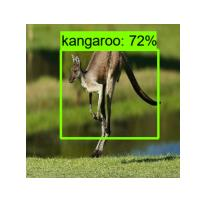

In [16]:
from IPython.display import Image, display

inference_path = "./inferences/inference.jpg"

# Display the saved image
display(Image(filename=inference_path))

### Test model on multiple images

In [17]:
import os
import glob

folder_path = "./images"

image_files = glob.glob(os.path.join(folder_path, '*.jpg')) + glob.glob(os.path.join(folder_path, '*.png'))

plt.figure(figsize=(20, 20))
min_score_thresh = 0.70  # Change minimum score for threshold

for i, image_path in enumerate(image_files):
    image_np_test = preprocess_input_image(image_path, input_image_size)
    
    pb_request = prepare_request(image_np_test)

    pb_response = stub.Predict(pb_request, timeout=20.0)

    result = pb_response.outputs

    visualization_utils.visualize_boxes_and_labels_on_image_array(  
        image_np_test[0],
        tf.make_ndarray(result['detection_boxes'])[0],
        tf.make_ndarray(result['detection_classes'])[0],
        tf.make_ndarray(result['detection_scores'])[0],
        category_index=category_index,
        use_normalized_coordinates=False,
        max_boxes_to_draw=200,  # 200
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4
    )
    
    plt.imshow(image_np_test[0])
    plt.axis('off')
    plt.plot()
    plt.savefig(f"./inferences/inference_{i}.jpg", dpi=10)

plt.show()

C:\Users\Javier\AppData\Local\Temp\ipykernel_19052\2864292801.py:39: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


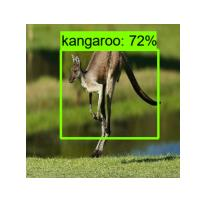

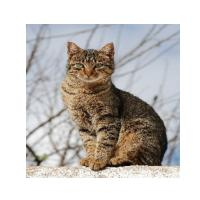

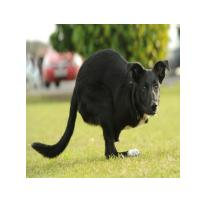

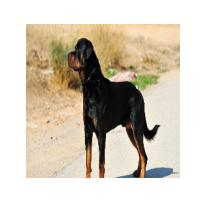

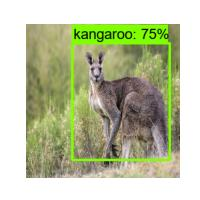

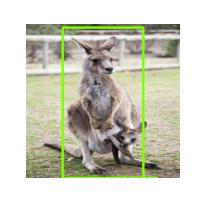

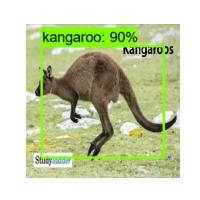

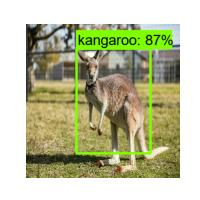

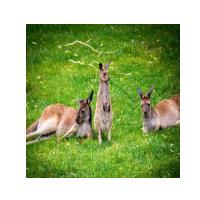

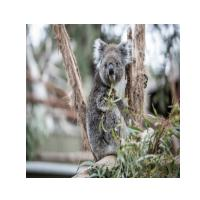

In [18]:
from IPython.display import Image, display

inference_path = "./inferences"

inference_image_files = glob.glob(os.path.join(inference_path, '*.jpg')) + glob.glob(os.path.join(inference_path, '*.png'))

# Display saved images
for i, inference_image in enumerate(inference_image_files):
    display(Image(filename=inference_image))

## 3. Creating a gateway service with Flask

The application consists of two components: a `Docker container` with Tensorflow Serving and a `Flask application` with the gateway service (which will be dockerized in the next section).

Save the code of the previous sections into a Flask app. The `gateway.py` script includes functions to preprocess the input image, prepare request, send request, and prepare response.

```python
app = Flask("gateway")

@app.route("/predict", methods=["POST"])
def predict_endpoint():
    data = request.get_json()
    url = data["url"]
    result = predict(url)

    return jsonify(result)
```

Since Tensorflow is a large library, we can use the `proto.py` script instead to convert numpy array into protobuf format. Import the `np_to_protobuf` function into our `gateway.py` script. For this, we will need to install `tensorflow-protobuf==2.7.0` ([tensorflow-protobuf](https://github.com/alexeygrigorev/tensorflow-protobuf)) and `protobuf==3.19`. We also use NumPy and Pillow for image preprocessing instead of TensorFlow utils.

In order to put everything in a `pipenv` environment for deployment, install the following libraries: 

```bash
$ pipenv install grpcio==1.42.0 flask gunicorn tensorflow-protobuf==2.7.0 protobuf==3.19 requests pillow==9.5.0 numpy
```

Run the model using the prebuilt Docker image with TensorFlow Serving, as explained in the previous section, and the Flask app `gateway.py` within the Pipenv environment:

```bash
$ pipenv shell
$ python gateway.py
```

Test the gateway with the `test.py` script:

```
$ python test.py

{'detection_boxes': [[35.14519500732422, 58.22978210449219, 192.72650146484375, 231.2527618408203], [27.200538635253906, 31.341506958007812, 256.0, 193.9303741455078], [59.97596740722656, 88.12405395507812, 210.4847869873047, 197.08651733398438], [37.73935317993164, 71.75199890136719, 145.4170379638672, 195.84808349609375], [55.022037506103516, 64.40953063964844, 99.29978942871094, 105.39948272705078], [102.12481689453125, 69.70646667480469, 222.62777709960938, 174.2012176513672], [63.597225189208984, 66.47791290283203, 105.66650390625, 90.24641418457031], [212.4785919189453, 11.457980155944824, 246.3284454345703, 31.470073699951172], [151.5824737548828, 106.23762512207031, 218.55007934570312, 144.2154541015625], [137.12179565429688, 114.39778137207031, 203.7748260498047, 160.0428009033203], [53.99766540527344, 62.74945068359375, 105.33444213867188, 136.0169219970703], [35.56243133544922, 0.5376167297363281, 74.31259155273438, 23.980180740356445], [42.10578155517578, 0.6401309967041016, 95.25769805908203, 39.71879577636719], [71.41671752929688, 58.42420959472656, 115.92938232421875, 102.091796875], [212.47254943847656, 19.378944396972656, 249.26095581054688, 40.61579513549805], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]], 'detection_classes': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'detection_scores': [0.5343912243843079, 0.14186212420463562, 0.1373942792415619, 0.11964446306228638, 0.07809022068977356, 0.07575884461402893, 0.07342135906219482, 0.0635799765586853, 0.062283337116241455, 0.05808436870574951, 0.05721864104270935, 0.05665856599807739, 0.05394500494003296, 0.05324357748031616, 0.051360249519348145, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], 'image_info': [256.0, 256.0, 256.0, 256.0, 1.0, 1.0, 0.0, 0.0], 'num_detections': [15]}
```

### Make a prediction request to the Flask App

In [1]:
import requests

image_url = "https://images.unsplash.com/photo-1551270988-87c5ea57cdfe"

url = "http://localhost:9696/predict"

data = {
    "url": image_url
}

result = requests.post(url, json=data).json()
# print(result)

In [2]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

C:\Users\Javier\miniconda3\envs\ml-zoomcamp\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Javier\miniconda3\envs\ml-zoomcamp\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file

In [3]:
import io
from PIL import Image
import numpy as np

In [4]:
def preprocess_input_image_from_url(image_url, input_image_size):
    response = requests.get(image_url)
    image = Image.open(io.BytesIO(response.content))
    image = image.resize(input_image_size)
    image_np = np.array(image)
    image_np = np.expand_dims(image_np, axis=0)

    image_np = image_np.astype(np.uint8)

    return image_np

In [5]:
import matplotlib.pyplot as plt

HEIGHT, WIDTH = 256, 256
input_image_size = (HEIGHT, WIDTH)

image_np = preprocess_input_image_from_url(image_url, input_image_size)

category_index={
    1: {
        'id': 1,
        'name': 'kangaroo'
       },
}

plt.figure(figsize=(20, 20))
min_score_thresh = 0.70  

visualization_utils.visualize_boxes_and_labels_on_image_array(  
    image_np[0],    
    np.array(result['detection_boxes']),
    np.array(result['detection_classes']),
    np.array(result['detection_scores']), 
    category_index=category_index,
    use_normalized_coordinates=False,
    max_boxes_to_draw=200,  # 200
    min_score_thresh=min_score_thresh,
    agnostic_mode=False,
    instance_masks=None,
    line_thickness=4
)

plt.imshow(image_np[0])
plt.axis('off')
plt.plot()
plt.savefig(f"./inferences/inference_flask.jpg", dpi=10)

plt.show()

C:\Users\Javier\AppData\Local\Temp\ipykernel_12848\924966402.py:37: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


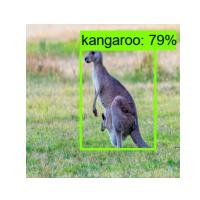

In [6]:
from IPython.display import Image, display

inference_path = "./inferences/inference_flask.jpg"
display(Image(filename=inference_path))